# Different `emcee` moves

The `emcee` library that is used for the random walk exploration of the parameter space has some options that are exposed in the SATLAS2 interface. One interesting option is the ability to change the algorithms used to propose moves. The `emcee` documentation contains a tutorial on how and why different moves can be used [here](https://emcee.readthedocs.io/en/stable/tutorials/moves/).

The exploration of the parameter space for hyperfine spectra does benefit from this option. The difference between the standard stretch move and the proposed mix of differential evolution move and snooker move will be explored.

In [1]:
import sys
import time
import emcee

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np

sys.path.insert(0, '..\..\..\src')

import satlas2

def modifiedSqrt(input):
    output = np.sqrt(input)
    output[input <= 0] = 1
    return output

## Data generation

The convenience function included in SATLAS2 is used to generate a Poisson distributed spectrum.

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 91
    # data points      = 87
    # variables        = 9
    chi-square         = 72.8990076
    reduced chi-square = 0.93460266
    Akaike info crit   = 2.61552097
    Bayesian info crit = 24.8086940
[[Variables]]
    Artificial___HFS___centroid:  -0.37055045 +/- 1.42164523 (383.66%) (init = 0)
    Artificial___HFS___Al:         51.4477619 +/- 1.39705770 (2.72%) (init = 50)
    Artificial___HFS___Au:         251.236334 +/- 1.65652941 (0.66%) (init = 250)
    Artificial___HFS___Bl:         12.5419832 +/- 2.59229524 (20.67%) (init = 10)
    Artificial___HFS___Bu:         4.34080560 +/- 1.74164467 (40.12%) (init = 5)
    Artificial___HFS___Cl:         0 (fixed)
    Artificial___HFS___Cu:         0 (fixed)
    Artificial___HFS___FWHMG:      56.0066443 +/- 10.2656213 (18.33%) (init = 50)
    Artificial___HFS___FWHML:      42.4534449 +/- 11.2048829 (26.39%) (init = 50)
    Artificial___HFS___scale:      205.225337

C:\Users\megat\Documents\git_repositories\personal\satlas2\docs\tutorials\walkoptions\..\..\..\src\satlas2\models\hfsModel.py:292: RuntimeWarning: invalid value encountered in scalar divide
  shift = phase * n / d


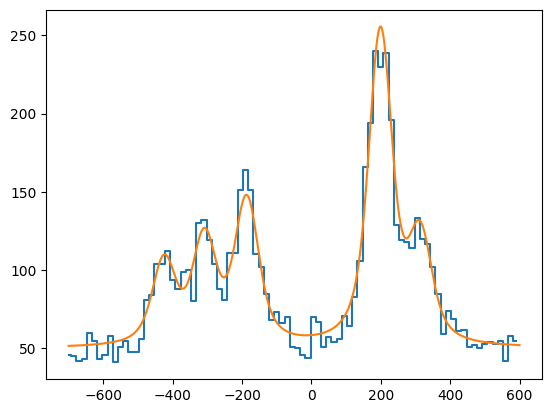

In [2]:
A = [50, 250]
B = [10, 5]
C = [0, 0]

I = 1.0
J = [1.0, 1.0]
df = 0
fwhmg = 50
fwhml = 50
scale = 200
bkg = 50

hfs = satlas2.HFS(I, J, A=A, B=B, C=C, df=df, fwhmg=fwhmg, fwhml=fwhml, scale=scale)
bkg = satlas2.Polynomial([bkg])

x = np.linspace(-700, 600, 1000)
data_x = np.arange(x.min(), x.max(), 15)
data_y = satlas2.generateSpectrum([hfs, bkg], data_x)

plt.plot(data_x, data_y, drawstyle='steps-mid')
plt.plot(x, hfs.f(x)+bkg.f(x))
f = satlas2.Fitter()
datasource = satlas2.Source(data_x, data_y, yerr=modifiedSqrt, name='Artificial')
datasource.addModel(hfs)
datasource.addModel(bkg)
f.addSource(datasource)
f.fit()
print(f.reportFit())

## Standard `emcee` move

The normal move used by `emcee` is called the StretchMove, and is used by not specifying any specific moves at all

In [3]:
stretchfile = 'stretchmove.h5'
f.fit(method='emcee', filename=stretchfile)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:28<00:00, 35.70it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 9 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [52.18497247 57.73151625 50.61482182 58.94721213 55.18218592 53.97033804
 51.2988931  56.19765179 49.45745584]


The warning here shows that, in order to get good estimates, more samples are recommended. For more information, see the `emcee` documentation. However, the important detail here is the list of autocorrelation times that is estimated here, which is about 50-60 steps.

Polynomial p0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 30.20it/s]


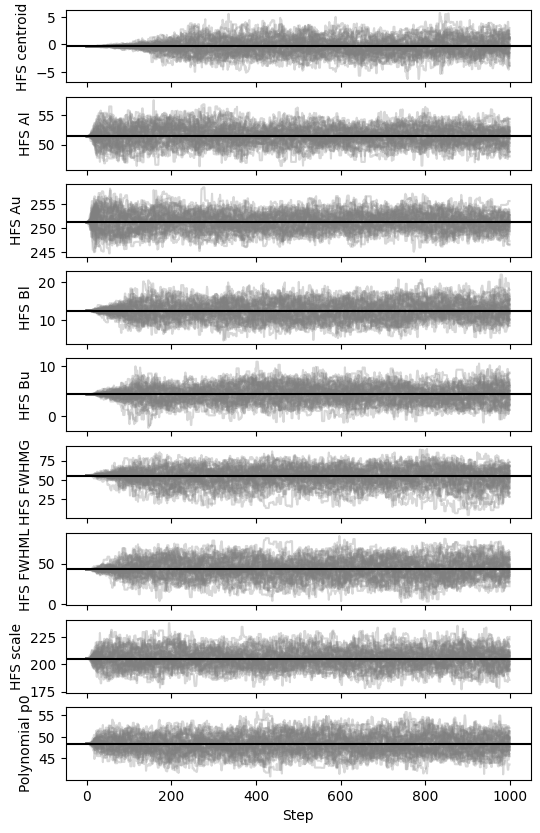

In [8]:
fig, axes = satlas2.generateWalkPlot(stretchfile)
fig.set_size_inches(6, 10)

Here, the burn-in is quite long for several parameters. If possible, avoiding long burn-ins is very useful to increase useful computation time.

## Using differential evolution moves

Starting from version 3, `emcee` has a Moves interface where the proposal for the random walk can be changed. In addition to specifying another algorithm, a selection of moves can be given along with a float that represents the chance the algorithm is selected. Giving an ensemble of move proposals in this way can improve overall performance.

As illustrated in the linked documentation, a combination of DEMove and DESnookerMove can perform better in highly dimensional or lightly multimodal distributions. Both of these descriptions can be well applied to the fitting of hyperfine spectra.

In [5]:
combinationfile = 'combination.h5'
f.revertFit()
f.fit(method='emcee', filename=combinationfile, sampler_kwargs={'moves': [
    (emcee.moves.DEMove(), 0.8),
    (emcee.moves.DESnookerMove(), 0.2)
]})

  4%|████████████▌                                                                                                                                                                                                                                                                                                            | 40/1000 [00:01<00:29, 32.49it/s]C:\Users\megat\AppData\Local\Temp\ipykernel_16656\1488049299.py:14: RuntimeWarning: invalid value encountered in sqrt
  output = np.sqrt(input)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:28<00:00, 35.65it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 9 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [25.79202768 28.04787132 31.15895649 27.02757601 27.06688899 32.62843194
 33.30301554 29.44226374 30.75024705]


As with the previous case, the recommendation is that a longer chain is used. However, the autocorrelation time is much shorter, 20-30 steps instead of the previous 50-60 steps. This corresponds to a walk that shows a much lower burn-in time.

Polynomial p0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 20.12it/s]


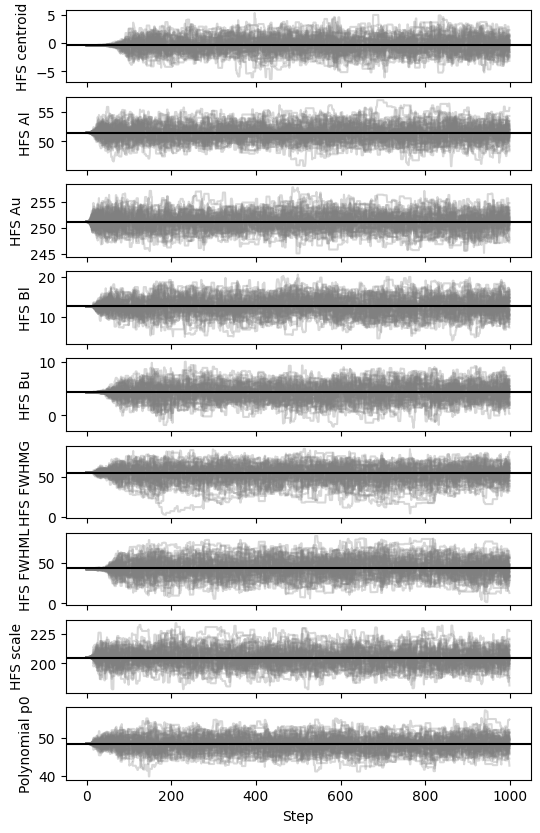

In [7]:
fig, axes = satlas2.generateWalkPlot(combinationfile)
fig.set_size_inches(6, 10)

This is clearly reflected in the resulting walk. Experimentation with the exact mixture of Moves can result in even better performance. Since SATLAS2 relies on the interface provided by emcee, any future Moves that are introduced can automatically be used in SATLAS2 for sampling.